# 1. Определение перспективного тарифа для телеком-компании

Цель исследования: предварительный анализ тарифов.  
Проверить гипотезы:  
средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.  
средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

## Шаг 1. Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import math as mt
import itertools

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

In [3]:
calls.info()
calls.describe(include = 'all').T
calls.sample(5, random_state=42)
#calls['duration'].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
158741,1392_406,2018-07-09,4.94,1392
95947,1244_202,2018-11-09,0.00,1244
10624,1027_494,2018-10-07,3.10,1027
167423,1412_340,2018-09-25,5.91,1412
73194,1184_168,2018-09-03,9.86,1184


В данных нет явных дубликатов и пропусков.  
В столбце duration звонки с нулевой продолжительностью. Это не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять.  
У столбца call_date неверный формат данных. Исправим в шаге предподготовки данных.

In [4]:
internet.info()
internet.describe(include = 'all').T
internet.sample(5, random_state=42)
internet.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


0

В данных нет пропусков, нет явных дубликатов.  
Есть дополнительный безымянный столбец с индексами. Вероятно появился при удалении дубликатов или при присоединении таблиц. В исследовании он не учавствует и не мешает. Можем оставить без изменений.  
У столбца session_date неверный формат данных. Исправим в шаге предподготовки данных.

In [5]:
messages.info()
messages.describe(include = 'all').T
messages.sample(5, random_state=42)
messages['id'].duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


0

В данных нет пропусков, нет явных дубликатов.  
У столбца message_date неверный формат данных. Исправим в шаге предподготовки данных.

In [6]:
users.info()
users.describe(include = 'all').T
users.sample(5, random_state=42)
#users.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
361,1361,38,NaN,Екатеринбург,Рената,Кошелева,2018-09-09,ultra
73,1073,63,NaN,Владикавказ,Гордей,Павловский,2018-10-04,smart
374,1374,67,NaN,Махачкала,Леонид,Аркадьев,2018-04-01,smart
155,1155,71,NaN,Ставрополь,Александр,Чернов,2018-01-02,smart
104,1104,60,NaN,Нижний Тагил,Габриэль,Поляков,2018-02-21,ultra


В данных нет явных дубликатов.  
В стобце churn_date в данных есть пропуски (Nan), но это связано с тем, что на момент выгрузки клиент всё ещё пользуется тарифом.  
У столбцов churn_date и reg_date неверный формат данных. Исправим в шаге предподготовки данных.

In [7]:
tariffs.info()
tariffs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Вывод: Необходимо привести к нужному типу данных столбцы с датами

## Шаг 2. Подготовьте данные

Приводим к нужному типу данных столбцы с датами

In [8]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format = '%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format = '%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format = '%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format = '%Y-%m-%d')

Добавим столбец с месяцем в таблицы с данными по звонкам, интернет траффику и сообщениям

In [29]:
calls['month']

0         2018-07
1         2018-08
2         2018-06
3         2018-09
4         2018-12
           ...   
202602    2018-12
202603    2018-10
202604    2018-11
202605    2018-10
202606    2018-12
Name: month, Length: 202607, dtype: period[M]

In [10]:
calls['month'] = pd.to_datetime(calls['call_date']).dt.to_period("M")
internet['month'] = pd.to_datetime(internet['session_date']).dt.to_period("M")
messages['month'] = pd.to_datetime(messages['message_date']).dt.to_period("M")

Округлим продолжительность всех звонков в большую сторону, согласно условиям тарифа

In [11]:
calls['duration_ceil'] = np.ceil(calls['duration'])
calls.head(5)

,id,call_date,duration,user_id,month,duration_ceil
0,1000_0,2018-07-25,0.00,1000,2018-07,0.0
1,1000_1,2018-08-17,0.00,1000,2018-08,0.0
2,1000_2,2018-06-11,2.85,1000,2018-06,3.0
3,1000_3,2018-09-21,13.80,1000,2018-09,14.0
4,1000_4,2018-12-15,5.18,1000,2018-12,6.0


Считаем для каждого пользователя количество сделанных звонков и израсходованных минут разговора по месяцам

In [12]:
calls_group = calls.pivot_table(index = ['user_id', 'month'], values = 'duration_ceil', aggfunc = ['count', 'sum'])
calls_group.columns = ['calls_count', 'calls_duration']
calls_group.head(10)

calls_count  calls_duration
user_id month                               
1000    2018-05           22           159.0
        2018-06           43           172.0
        2018-07           47           340.0
        2018-08           52           408.0
        2018-09           58           466.0
        2018-10           57           350.0
        2018-11           43           338.0
        2018-12           46           333.0
1001    2018-11           59           430.0
        2018-12           63           414.0

Посчитаем для каждого пользователя количество отправленных сообщений по месяцам

In [13]:
messagess_group = messages.pivot_table(index = ['user_id', 'month'], values = 'id', aggfunc = 'count')
messagess_group.columns = ['messages_count']

Переведём, использованный объём интернет-траффика в гигабайты

In [14]:
internet['gb_used'] = internet['mb_used'] / 1024
internet.sample(5, random_state=42)

,Unnamed: 0,id,mb_used,session_date,user_id,month,gb_used
31737,31737,1110_331,351.71,2018-09-04,1110,2018-09,0.343467
31333,31333,1109_399,257.69,2018-06-09,1109,2018-06,0.251650
61121,61121,1207_191,128.18,2018-11-05,1207,2018-11,0.125176
71184,71184,1241_88,736.71,2018-11-23,1241,2018-11,0.719443
84394,84394,1286_76,900.69,2018-12-18,1286,2018-12,0.879580


Посчитаем для каждого пользователя объем израсходованного интернет-трафика по месяцам

In [15]:
internet_group = internet.pivot_table(index = ['user_id', 'month'], values = 'gb_used', aggfunc = 'sum')
internet_group.columns = ['traffic_amount']

Переведём, объём интернет-траффика в гигабайты в таблице тарифов

In [16]:
tariffs['gb_per_month_included'] = tariffs['mb_per_month_included'] / 1024

Сделаем общую сводку для каждого пользователя по месяцам

In [18]:
call_messagess = calls_group.merge(messagess_group, on=['user_id', 'month'], how = 'outer')
data = call_messagess.merge(internet_group, on=['user_id', 'month'], how = 'outer').reset_index(level='month')
len(data)

3214

Добавим к данным по каждому пользователю тариф и город

In [19]:
data = data.merge(users[['user_id','tariff','city']], on = 'user_id')

Округлим количество использованного интерент трафика в большую сторону, согласно условиям тарифа

In [20]:
data['traffic_amount'] = np.ceil(data['traffic_amount'])
data.sample(5, random_state=42)

,user_id,month,calls_count,calls_duration,messages_count,traffic_amount,tariff,city
506,1080,2018-12,123.0,904.0,71.0,5.0,ultra,Москва
2513,1395,2018-11,91.0,637.0,26.0,19.0,smart,Москва
354,1056,2018-05,55.0,462.0,49.0,18.0,smart,Иркутск
1080,1173,2018-10,119.0,841.0,14.0,21.0,smart,Красноярск
2389,1380,2018-07,106.0,806.0,26.0,38.0,ultra,Ростов-на-Дону


Проверим полученную таблицу на пропуски

In [21]:
data.isnull().sum()

user_id             0
month               0
calls_count        40
calls_duration     40
messages_count    497
traffic_amount     11
tariff              0
city                0
dtype: int64

Пропуски, по всей вероятности, связаны с тем, что в некоторые месяцы клиенты не звонили и/или не пользовались сообщениями или интернетом. Заполняем их нулевыми значениями

In [22]:
data = data.fillna(0)

Посчитаем помесячную выручку с каждого пользователя (вычтитаем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножаем на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану).

In [23]:
def payment_calculation(row):
    calls = row['calls_count']
    duration = row['calls_duration']
    messages = row['messages_count']
    traffic = row['traffic_amount']
    tariff = row['tariff']
    
    if tariff == 'smart':
        over_duration = duration - tariffs.loc[0, 'minutes_included']
        over_messages = messages - tariffs.loc[0, 'messages_included']
        over_traffic = traffic - tariffs.loc[0, 'gb_per_month_included']
                
        if over_duration < 0: over_duration = 0
        if over_messages < 0: over_messages = 0
        if over_traffic < 0: over_traffic = 0
        
        return (tariffs.loc[0, 'rub_monthly_fee'] + tariffs.loc[0, 'rub_per_minute'] * over_duration + 
                tariffs.loc[0, 'rub_per_message'] * over_messages + tariffs.loc[0, 'rub_per_gb'] * over_traffic)


    else:
        over_duration = duration - tariffs.loc[1, 'minutes_included']
        over_messages = messages - tariffs.loc[1, 'messages_included']
        over_traffic = traffic - tariffs.loc[1, 'gb_per_month_included']
        
        if over_duration < 0: over_duration = 0
        if over_messages < 0: over_messages = 0
        if over_traffic < 0: over_traffic = 0
        
        return (tariffs.loc[1, 'rub_monthly_fee'] + tariffs.loc[1, 'rub_per_minute'] * over_duration + 
                tariffs.loc[1, 'rub_per_message'] * over_messages + tariffs.loc[1, 'rub_per_gb'] * over_traffic)

data['payment'] = data.apply(payment_calculation, axis=1)
data.sample(5, random_state=42)

,user_id,month,calls_count,calls_duration,messages_count,traffic_amount,tariff,city,payment
506,1080,2018-12,123.0,904.0,71.0,5.0,ultra,Москва,1950.0
2513,1395,2018-11,91.0,637.0,26.0,19.0,smart,Москва,1761.0
354,1056,2018-05,55.0,462.0,49.0,18.0,smart,Иркутск,1150.0
1080,1173,2018-10,119.0,841.0,14.0,21.0,smart,Красноярск,2773.0
2389,1380,2018-07,106.0,806.0,26.0,38.0,ultra,Ростов-на-Дону,3150.0


## Шаг 3. Проанализируйте данные

Сделаем расчёт: сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?

In [24]:
tariff_in_use = data.pivot_table(index = ['tariff','month'], 
                 values = ['calls_duration', 'messages_count', 'traffic_amount', 'payment'], 
                 aggfunc = 'mean').reset_index()
tariff_in_use

,tariff,month,calls_duration,messages_count,payment,traffic_amount
0,smart,2018-01,203.852941,18.235294,721.323529,8.735294
1,smart,2018-02,298.689655,24.086207,827.603448,11.844828
2,smart,2018-03,390.051948,31.857143,1164.623377,15.233766
3,smart,2018-04,367.133929,30.741071,963.089286,13.625000
4,smart,2018-05,387.361702,33.773050,1197.510638,15.907801
5,smart,2018-06,395.640244,33.402439,1204.018293,15.951220
6,smart,2018-07,408.353234,33.751244,1223.950249,15.875622
7,smart,2018-08,421.468085,33.638298,1320.595745,16.736170
8,smart,2018-09,428.611538,33.638462,1249.946154,16.392308
9,smart,2018-10,426.136054,33.765306,1364.853741,16.880952


Строим гистограммы

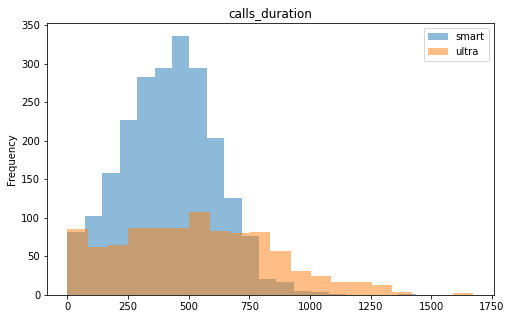

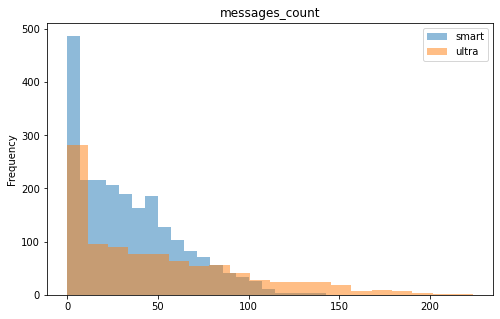

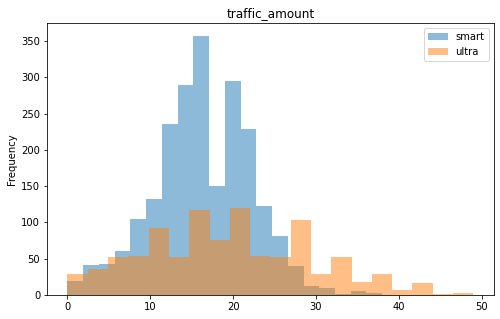

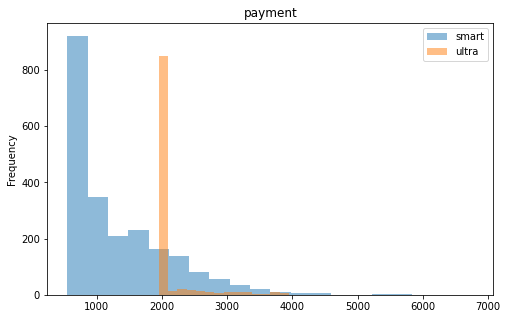

In [25]:
columns=['calls_duration','messages_count','traffic_amount','payment']
tariffs = ['ultra','smart']
for column in columns:
        data.loc[data.loc[:,'tariff'] == 'smart'][column].plot(
                                                                            kind = 'hist',
                                                                            bins = 20,
                                                                            alpha = 0.5,
                                                                            label = 'smart', figsize = (8,5)
                                                                           )
        data.loc[data.loc[:,'tariff'] == "ultra"][column].plot(
                                                                            kind = 'hist',
                                                                            bins = 20,
                                                                            alpha = 0.5,
                                                                            label = 'ultra',figsize = (8,5)
                                                                           )
        plt.title(column)
        plt.legend()
        plt.show()

По продолжительности звонков у тарифа smart пик на 500 минутах, у тарифа ultra пиковые значение около 550 минут, но в целом не так явно выражены. Так же стоит обратить внимание, что клиенты тарифа ultra не используют полностью предложенное в тарифе количество минут разговора.  
По количеству СМС для обоих тарифов характерно, что часть клиентов не использует или крайне мало использует данную категорию связи. Пользователи тарифа smart чаще превышают базовый пакет, тогда как пользователи ultra, как и в случае со звонками, не используют полностью заложенное в тариф количество СМС.  
По объёму интернет траффика у тарифа smart два пика - 15 и 19 гигабайт. Для ultra график имеет несколько пиковых значений. Клинеты обоих тарифов превышают базовый пакет.  
По выручке заметно, что большая часть пользователей ultra укладывается в рамки стоимости тарифного плана. Для smart по всем опциям характерно превышение базового пакета, соответствеено это отражается и на выручке.

Посчитаем среднее количество, дисперсию и стандартное отклонение для пользователей каждого тарифа

In [26]:
data.pivot_table(index = 'tariff', values = ['calls_duration', 'messages_count', 'traffic_amount', 'payment'], 
                               aggfunc = ['mean', 'var', 'std']).reset_index()

tariff           mean                                             \
         calls_duration messages_count      payment traffic_amount   
0  smart     417.934948      33.384029  1289.973531      16.328847   
1  ultra     526.623350      49.363452  2070.152284      19.494416   

             var                                                         std  \
  calls_duration messages_count        payment traffic_amount calls_duration   
0   36219.315784     796.812958  669785.708006      33.028705     190.313730   
1  100873.633397    2285.266143  141516.745079      97.091686     317.606098   

                                             
  messages_count     payment traffic_amount  
0      28.227876  818.404367       5.747061  
1      47.804457  376.187114       9.853511

## Шаг 4. Проверьте гипотезы

Нулевая гипотеза: средняя выручка пользователей тарифов «Ультра» и «Смарт» равны;  
Альтернативная гипотеза: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;

In [27]:
alpha = 0.05
results = st.ttest_ind(
    tariff_in_use.loc[tariff_in_use['tariff'] == 'smart']['payment'], 
    tariff_in_use.loc[tariff_in_use['tariff'] == 'ultra']['payment'],
    equal_var=False
)
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 3.2027925855703315e-08
Отвергаем нулевую гипотезу


Нулевая гипотеза: Средняя выручка пользователей из Москвы равна выручке пользователей из других регионов.  
Альтернативная гипотеза: Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [28]:
alpha = 0.05

results = st.ttest_ind(
    data.loc[data['city'] == 'Москва']['payment'], 
    data.loc[data['city'] != 'Москва']['payment']
)
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5440152911670224
Не получилось отвергнуть нулевую гипотезу


## Вывод

По результатам анализа удалось опровергнуть гипотезу о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» равны:
клиенты, использвующие тариф «Смарт», в среднем платят на 37% больше (1290 руб против 2070 руб соответственно).  
  
Была подтверждена гипотеза о том, что средняя выручка от пользователей в Москве не отличаются от выручки пользователей из других регионов.  
  
Пользователи «Ультра» не используют полностью тарифное предложение по количеству минут и сообщений.
  
Пользователи «Смарт» наоборот превышают базовый пакет и в среднем доплачивают 740 руб. в месяц.